# SEBAL Model with Meteorological data 
Sebal Model implementation with actual meteorological data and chosen Landsat 8 scenes from MesoHyd Project, Leipzig University. \
Data provided by Christopher Hutengs.
  

In [ ]:

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rioxarray.merge import merge_arrays
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import math
import spyndex
#import earthpy as et
#import earthpy.spatial as es
#import earthpy.plot as ep
import tarfile
import pathlib
#import geowombat



import glob
import os
import os.path
import sys

In [20]:
# Path Conversion Tool
pathlib.PureWindowsPath(r"D:\Nicolas_D\Geodaten\Masterarbeit\DATA_MesoHyd_MA-SEBAL\Processed\study_area").as_posix()


'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/study_area'

# Import data/Test
Get help/tutorial from https://www.earthdatascience.org/courses/use-data-open-source-python/

### Configure Data Access (Date, ...)

In [2]:

# Set date(s) of modelling/data retrieval
date = "2015-07-04"
date = pd.to_datetime(date, format = "%Y-%m-%d")
print("Date normal =", date)
print(type(date))

# Date in INTERMET-Raster Path Format
date_met = date.date()
date_met = date_met.strftime('%Y-%m-%d')
print("Date INTERMET =", date_met)
print(type(date_met))

# Date in WASIM-Raster Path Format
date_wasim = date.date()
date_wasim = date_wasim.strftime('%Y_%m_%d').replace("_0", "_")
print("Date WASIM =", date_wasim)
print(type(date_wasim))

# Date in Landsat Path Format
date_LS = date.date()
date_LS = date_LS.strftime('%Y%m%d')
print("Date Landsat =", date_LS)
print(type(date_LS))


Date normal = 2015-07-04 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Date INTERMET = 2015-07-04
<class 'str'>
Date WASIM = 2015_7_4
<class 'str'>
Date Landsat = 20150704
<class 'str'>


### Import Landsat 8 data - VIS/NIR

In [2]:
path = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/LANDSAT"
data = sorted(glob.glob(path + "/*.tar"))
data = data[1]


In [3]:
path2 = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/"
path3 = data[74:-4]
#path3 = print(path2, data[74:-4], sep = "")


In [4]:
path_combined = os.path.join(path2, path3)
path_combined
#os.mkdir(path_combined)

'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1'

In [49]:
#tar = tarfile.open(data)
#tar.extractall(path = path_combined)
#tar.close()

In [5]:
data = sorted(glob.glob(path_combined + "/*.tif"))
data


['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_QA_PIXEL.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_QA_RADSAT.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_SR_B1.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_SR_B2.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_SR_B3.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_1960

In [6]:
# open Metadatafile for extracting scale factors for VIIRS
meta_path = sorted(glob.glob(path_combined + "/*MTL.txt"))
meta = pd.read_csv(meta_path[0], sep = "=")
meta.iloc[:,0]

# Load and convert mutliplicative scale factor
scale_factor = meta[meta.iloc[:,0].str.contains("REFLECTANCE_MULT_BAND_1")].iloc[0,1]
scale_factor = float(scale_factor)
print("Scale factor =", scale_factor)

# Load and convert additive offset
scale_add = meta[meta.iloc[:,0].str.contains("REFLECTANCE_ADD_BAND_1")].iloc[0,1]
scale_add = float(scale_add)
print("Additive offset =", scale_add)

Scale factor = 2.75e-05
Additive offset = -0.2


In [7]:
# open Metadatafile for extracting scale factors for THERMAL
# Load and convert mutliplicative scale factor for Band 10 (Surface Temp in Kelvin)
scale_factor_thermal = meta[meta.iloc[:,0].str.contains("TEMPERATURE_MULT_BAND_ST_B10")].iloc[0,1]
scale_factor_thermal = float(scale_factor_thermal)
print("Scale factor Thermal =", scale_factor_thermal)

# Load and convert additive offset for Band 10 (Surface Temp in Kelvin)
scale_add_thermal = meta[meta.iloc[:,0].str.contains("TEMPERATURE_ADD_BAND_ST_B10")].iloc[0,1]
scale_add_thermal = float(scale_add_thermal)
print("Additive offset Thermal =", scale_add_thermal)


Scale factor Thermal = 0.00341802
Additive offset Thermal = 149.0


In [8]:
stack_dict = dict()

for i in range(2, 9):
    band_i = rxr.open_rasterio(data[i], masked = True).squeeze()
    band_corr = band_i*scale_factor+scale_add
    globals()[f"band_{i-1}"] = band_corr
    #print([f"band_{i-1}"])
    stack_dict[f"band_{i-1}"] = band_corr


In [9]:
# Add other needed bands to dictionary
# Band 10 Surface Temperature
stack_dict["band_10"] = rxr.open_rasterio(data[11], masked = True).squeeze()*scale_factor_thermal+scale_add_thermal

# Thermal Radiance TRAD
stack_dict["band_trad"] = rxr.open_rasterio(data[17], masked = True).squeeze()*0.001

# Emissivity estimated from ASTER_GED
stack_dict["emis"] = rxr.open_rasterio(data[14], masked = True).squeeze()*0.0001

# Level 2 Quality Pixel Band
stack_dict["QA_PIXEL"] = rxr.open_rasterio(data[0], masked = True).squeeze()

In [10]:
# Convert dictionaries xarrays into xr.Dataset
print(stack_dict.keys())
LS_stack = xr.Dataset(stack_dict)

dict_keys(['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7', 'band_10', 'band_trad', 'emis', 'QA_PIXEL'])


### Import Landsat 8 data - Thermal

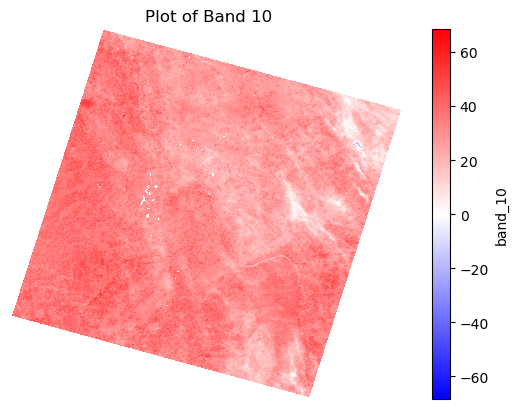

In [59]:
# T in Celsius
band_10_cels = LS_stack.band_10 - 273.15


# Colormap 
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["b", "w", "r"], N=256) 




# Plot the data
f, ax=plt.subplots()
band_10_cels.plot.imshow(ax=ax,
                  cmap=cmap)
ax.set_axis_off()
ax.set_title("Plot of Band 10")
plt.show()

In [60]:
print("Min:", np.nanmin(LS_stack.band_10.values))
print("Max:", np.nanmax(LS_stack.band_10.values))


Min: 244.18161
Max: 341.5063


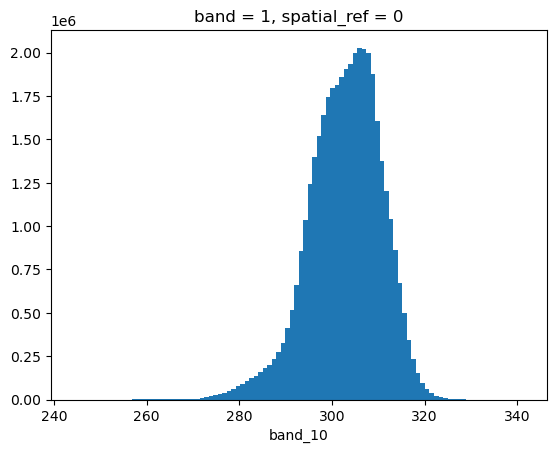

In [61]:
LS_stack.band_10.plot.hist(bins = 100)
plt.show()

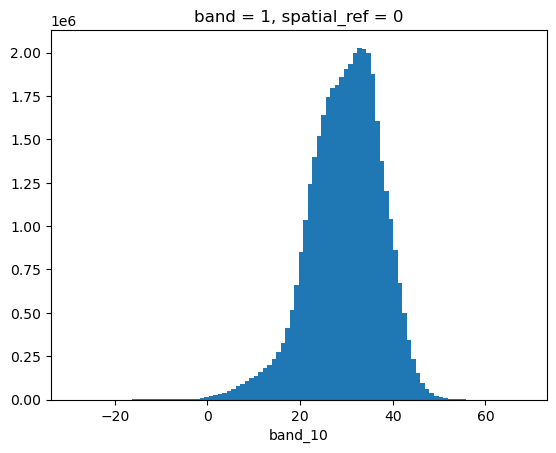

In [62]:
band_10_cels.plot.hist(bins = 100)
plt.show()

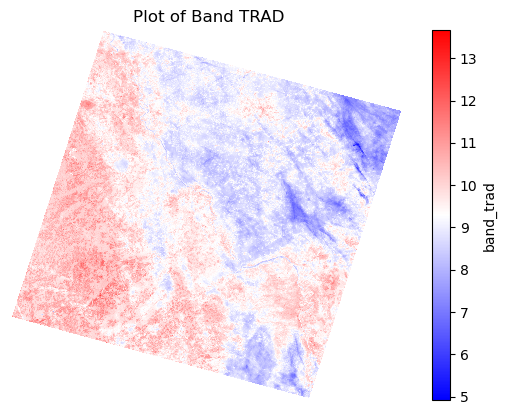

In [64]:
# Colormap 
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["b", "w", "r"], N=256) 

# Plot the data
f, ax=plt.subplots()
LS_stack.band_trad.plot.imshow(ax=ax,
                  cmap=cmap)
ax.set_axis_off()
ax.set_title("Plot of Band TRAD")
plt.show()

# Processing Steps

## 1. Preprocessing

### 1. Satellite Data

#### 1.1 Crop Satellite Data with Catchment Shapes


In [61]:
# Load Shapefile for Catchments
path_shapeA = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/study_area/altenbamberg_catchment.gpkg"
shape_alten = gpd.read_file(path_shapeA)

path_shapeK = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/study_area/kellenbach_catchment.gpkg"
shape_kellen = gpd.read_file(path_shapeK)

# Combine both Catchment Shapes
shape_catchments = pd.concat([shape_alten, shape_kellen])

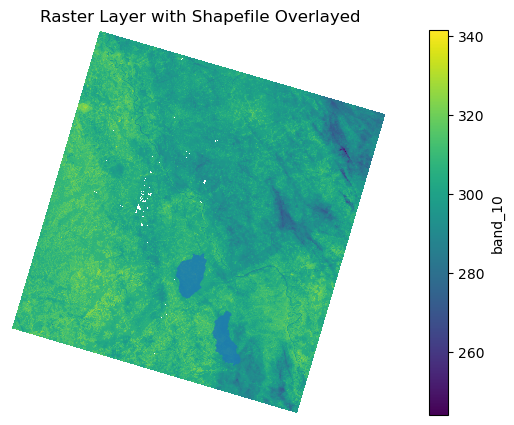

In [13]:
# Plot Catchments within Raster
f, ax = plt.subplots(figsize=(10, 5))
LS_stack.band_10.plot.imshow(ax=ax)

shape_catchments.plot(ax=ax,
                 alpha=.8)
ax.set(title="Raster Layer with Shapefile Overlayed")


ax.set_axis_off()
plt.show()

In [14]:
# Clip Landsat Raster with Shapefile
LS_stack_clip = LS_stack.rio.clip(shape_catchments.geometry, all_touched = True)

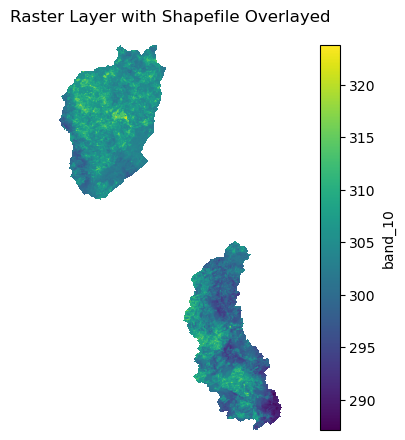

In [15]:
# Plot Catchments within Raster
f, ax = plt.subplots(figsize=(10, 5))
LS_stack_clip.band_10.plot.imshow(ax=ax)

shape_catchments.plot(ax=ax,
                alpha=0)
ax.set(title="Raster Layer with Shapefile Overlayed")


ax.set_axis_off()
plt.show()

In [16]:
# Safe cliped and processed raster stack to NetCDF
LS_stack_clip_float32 = LS_stack_clip.astype(np.float32)
LS_stack_clip_float32.to_netcdf("D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LS_Processed/LS08_20150704.nc")


In [3]:
# Load Cliped and processed raster stack (NetCDF)
LS_stack_clip = rxr.open_rasterio("D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LS_Processed/LS08_20150704.nc")

# Print Properties with reloaded "new" LS_stack_clip (from NetCDF file)
#print(LS_stack_clip)
#print(LS_stack_clip.rio.crs)

# Fix issues if lost CRS and lat/long dimensions of loaded LS_stack_clip from NetCDF
#LS_stack_clip = LS_stack_clip.rename({"x": "long", "y": "lat"})
#LS_stack_clip = LS_stack_clip.sortby(["band", "lat", "long"])
LS_stack_clip.rio.write_crs("epsg:32632", inplace=True)
LS_stack_clip = LS_stack_clip.squeeze()



#### 1.2 Apply Cloud Mask (Quality Assessment Band)
Steps by https://pages.cms.hu-berlin.de/EOL/gcg_eo/02_data_quality.html

In [4]:
# Mask any values other than "Clear with low confidence on Clouds"
LS_stack = LS_stack_clip.where(LS_stack_clip.QA_PIXEL.values == 21824)

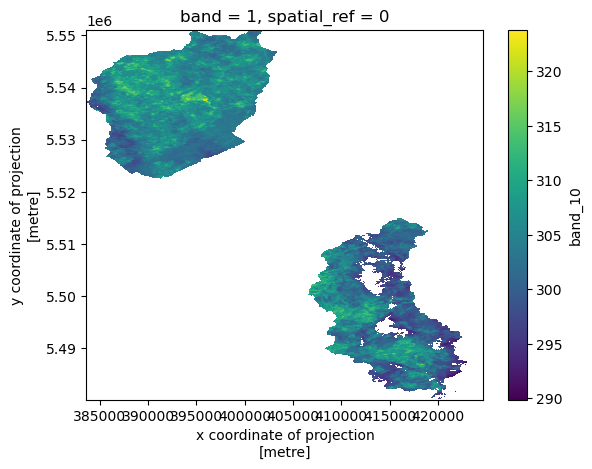

In [5]:
LS_stack.band_10.plot()

In [55]:
# Export LS_stack (with cloud mask)
LS_stack_path = 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LS_Processed/LS08_20150704_band_10.tif'

with rio.open(LS_stack_path, 
         mode = "w", 
         driver = "GTiff", 
         height = LS_stack.band_10.shape[0],
         width = LS_stack.band_10.shape[1],
         count = 1,
         dtype = LS_stack.band_10.dtype, 
         crs = "epsg:32632"
) as new_dataset:
    new_dataset.write(LS_stack.band_10.squeeze(), 1)

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\rasterio\__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


### 2. Land Use Map

In [5]:
# Open Corine Land Use Maps for both catchments
path_LUA = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/study_area/altenuse-ch.tif"
LU_alten = rxr.open_rasterio(path_LUA).squeeze()


path_LUK = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/study_area/kelleuse-ch.tif"
LU_kellen = rxr.open_rasterio(path_LUK).squeeze()


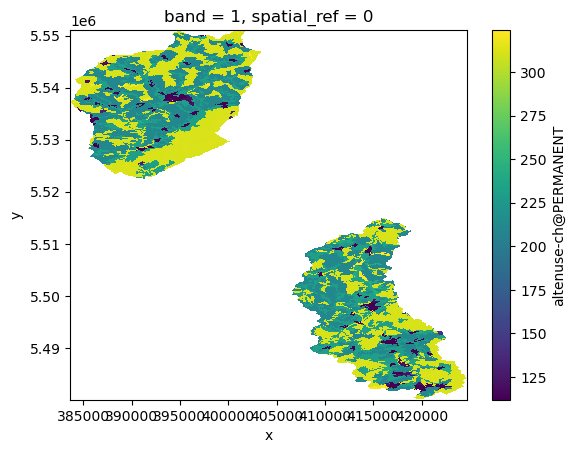

In [6]:
# Merge rasters 
LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
LU_mosaic .rio.write_crs("epsg:32632", inplace=True)
LU_mosaic.plot()

In [10]:
# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = LU_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

LU_mosaic = xds_repr_match

print(LU_mosaic.rio.resolution())
print(LS_stack.rio.resolution())

(30.0, -30.0)
(30.0, -30.0)


In [11]:
# Export LU Raster to check in QGIS

with rio.open('D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/study_area/LU_raster.tif', 
         mode = "w", 
         driver = "GTiff", 
         height = LU_mosaic.shape[0],
         width = LU_mosaic.shape[1],
         count = 1,
         dtype = LU_mosaic.dtype, 
         crs = "epsg:32632"
) as new_dataset:
    new_dataset.write(LU_mosaic, 1)

### 3. Meteorolocial Data

#### 3.1 Wind
Load and process wind data (Station data, one point per catchment, from WASIM Meteo Data)


In [14]:
# Read Wind tables from meteo data
path_meteo: str = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/meteo_original/"
path_wind_alten: str = path_meteo + "Wind2010_alten.txt"
path_wind_kellen: str = path_meteo + "Wind2010_kellen.txt"
wind_alten = pd.read_csv(path_wind_alten, delimiter = "\t", header = [3])
wind_kellen = pd.read_csv(path_wind_kellen, delimiter = "\t", header = [3])

# Change Hour to Start time of day at 00:00 midnight 
wind_alten.iloc[:,3] = wind_alten.iloc[:,3]-1 
wind_kellen.iloc[:,3] = wind_kellen.iloc[:,3]-1 

# Create DateTimeIndex based on Date columns
alten_wind_date_index = pd.to_datetime(wind_alten.iloc[:,0:4].astype(str).agg("-".join, axis = 1), format = "%Y-%m-%d-%H")
kellen_wind_date_index = pd.to_datetime(wind_kellen.iloc[:,0:4].astype(str).agg("-".join, axis = 1), format = "%Y-%m-%d-%H")

# Built final wind dataframe
wind_alten_df = wind_alten.iloc[:,4].to_frame()
wind_kellen_df = wind_kellen.iloc[:,4].to_frame()

# Add Date Index
wind_alten_df = wind_alten_df.set_index([alten_wind_date_index])
wind_kellen_df = wind_kellen_df.set_index([kellen_wind_date_index])

# Outer Join for both data frames Altenbamberg and Kellenbach
wind_df = pd.concat([wind_alten_df, wind_kellen_df], axis = 1)
wind_df.columns = ["wind_altenbamberg", "wind_kellenbach"]
wind_df.index.name = "date"
wind_df

# Export to csv
# wind_df.to_csv("D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/meteo_processed/wind_velocity.csv")



wind_altenbamberg  wind_kellenbach
date                                                   
2009-01-01 00:00:00                NaN              0.0
2009-01-01 01:00:00                NaN              0.0
2009-01-01 02:00:00                NaN              0.0
2009-01-01 03:00:00                NaN              0.0
2009-01-01 04:00:00                NaN              0.4
...                                ...              ...
2020-12-31 19:00:00                0.7              1.1
2020-12-31 20:00:00                0.7              1.3
2020-12-31 21:00:00                0.5              1.4
2020-12-31 22:00:00                0.2              0.9
2020-12-31 23:00:00                0.3              0.5

[105192 rows x 2 columns]

<Axes: >

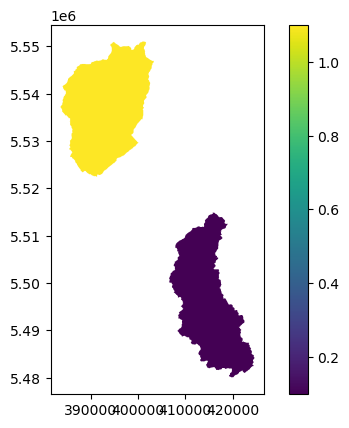

In [117]:
# Extracting Wind Speed for respective Date and add to map per Catchment
wind_day = pd.Series([wind_df.loc[date][1], wind_df.loc[date][0]], index = [0,0])
wind_map = shape_catchments.assign(wind = wind_day)
wind_map.plot(column = "wind", legend = True)

In [124]:
# Make wind_map usable within rasters
# based on https://kodu.ut.ee/~kmoch/geopython2020/L5/raster.html#calculating-zonal-statistics
wind_mask = rio.mask.mask(LS_stack.band_10, wind_map.wind, nodata = np.nan)

AttributeError: 'DataArray' object has no attribute 'transform'

## 2. Surface Radiation Balance

### 2.1 NDVI, SAVI, LAI

In [15]:
# NDVI
# NDVI = (band_5 - band_4) / (band_5 + band_4)

NDVI = spyndex.computeIndex(
    index = "NDVI",
    params = {
        "N": LS_stack.band_5,
        "R": LS_stack.band_4
    }
)

In [16]:
# SAVI
# SAVI = (1+L_savi)*(band_5 - band_4) / (L_savi+band_5 + band_4)
L_savi = 0.5       # Value should be adjusted according to Soil Moisture (0.1 and 0.5 are suggested)

SAVI = spyndex.computeIndex(
    index = "SAVI",
    params = {
        "L": L_savi,
        "N": LS_stack.band_5,
        "R": LS_stack.band_4
    }
)

In [17]:
# LAI
LAI = -(np.log((0.69-SAVI)/0.59)/0.91) 

### 2.2 Albedo
First Test Calculation from LS8 Reflectances based on https://yceo.yale.edu/how-convert-landsat-dns-albedo
Caution: intended for TOA, but here used with BOA-Reflectances

In [19]:
B1 = LS_stack.band_2     # Blue
B2 = LS_stack.band_4     # Red
B3 = LS_stack.band_5     # NIR 1 (0.76-0.9)
B4 = LS_stack.band_6     # NIR 2 (1.55-1.75)
B5 = LS_stack.band_7     # MIR (2.08-2.35)


albedo = ((0.356*B1) + (0.130*B2) + (0.373*B3) + (0.085*B4) + (0.072*B5) -0.018) / 1.016

### 2.3 Rs - Incoming Shortwave Radiation
#### 2.3.1 Easy Formula Approach from SEBAL_manual

In [22]:
# Rs Incoming - Easy Formula Approach from SEBAL_manual
# RS_incoming in W/m²

Gsc = 1367                  # Solar Constant in W/m²

# Solar Incidence Angle 
sun_elev = 39.24065277      # Sun elevation angle in degree, from Metadata_file
solar_inc = 90-sun_elev     # Solar Incidence Angle

# dr
DOY = 263                   # DOY of 19. September 2020
dr = 1+0.033*math.cos(DOY*(2*math.pi/365))  # relative sun-earth-distance dr 

# Atmospheric transmissivity
z = 104     # elevation above sea level (m) for Station (here: Bad Kreuznach elevation)     
tau_sw = 0.75+2*10**-5*z

# RS_incoming in W/m² (should be between 200 and 1000)
RS_in = Gsc * math.cos(solar_inc) * dr * tau_sw
RS_in

899.7472321021972

#### 2.3.2 Use of Spatial Radiation Data from INTERMET and/or WASIM-Model

In [23]:
# Create Path for recursive file search based on defined date
path_intermet = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/meteo_raster_daily/"
pattern = f"*rad*{date_wasim}*.tif"
#paths_intermet_rad = 
paths_intermet_rad = sorted(glob.glob(os.path.join(path_intermet, "**", pattern), recursive=True))
print(paths_intermet_rad)

# Open INTERMET Radiation Rasters and set Lat/Long/CRS
# Catchment Altenbamberg
intermet_rad_alten = rxr.open_rasterio(paths_intermet_rad[0]).squeeze()
intermet_rad_alten = intermet_rad_alten.where(intermet_rad_alten > 0)
#intermet_rad_alten = intermet_rad_alten.rename({"x": "long", "y": "lat"})
#intermet_rad_alten = intermet_rad_alten.sortby(["lat", "long"])
intermet_rad_alten.rio.write_crs("epsg:31466", inplace=True)

# Catchment Kellenbach
intermet_rad_kellen = rxr.open_rasterio(paths_intermet_rad[1]).squeeze()
intermet_rad_kellen = intermet_rad_kellen.where(intermet_rad_kellen > 0)
#intermet_rad_kellen = intermet_rad_kellen.rename({"x": "long", "y": "lat"})
#intermet_rad_kellen = intermet_rad_kellen.sortby(["lat", "long"])
intermet_rad_kellen.rio.write_crs("epsg:31466", inplace=True)



['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/meteo_raster_daily\\alten_radiation\\rad_raster_alten_2015_7_4.tif', 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/meteo_raster_daily\\kelle_radiation\\rad_raster_kelle_2015_7_4.tif']


<xarray.DataArray (y: 30, x: 20)>
array([[      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan, 302.70834,       nan,
              nan,       nan,       nan,       nan, 303.70834, 303.5    ,
              nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan, 302.625  , 303.16666,
        303.54166, 303.79166, 303.75   , 303.83334, 303.79166, 303.625  ,
              nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan, 302.33334, 302.95834,
        303.33334, 303.66666, 303.79166, 303.83334, 303.79166, 303.75   ,
              nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan, 301.16666, 302.125  , 302.70834,
        303.20834, 303.5    , 303.79166, 303.95834, 303.875  , 303.83334,
        303.875  ,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan, 298.83334, 300.     , 301.     , 301.91666, 302.45834,
        303.08334, 303.45834, 303.79166, 303.83334, 303.95834, 303.91666,
        303.95834, 303.79166],
...
       [      nan,       nan, 298.45834, 299.375  , 299.875  , 300.29166,
        300.75   , 301.16666, 301.41666, 301.79166, 302.25   , 302.54166,
        302.95834,       nan,       nan,       nan,       nan,       nan,
              nan,       nan],
       [      nan,       nan,       nan, 300.     , 300.33334, 300.79166,
        301.20834, 301.375  , 301.79166, 302.25   , 302.45834, 302.70834,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan],
       [      nan,       nan,       nan,       nan, 300.95834, 301.29166,
        301.66666, 301.75   , 302.20834, 302.45834, 302.79166,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan],
       [      nan,       nan,       nan,       nan,       nan, 301.875  ,
        302.04166, 302.16666, 302.54166, 302.66666,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan, 302.58334, 302.83334,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 2.599e+06 2.6e+06 2.601e+06 ... 2.617e+06 2.618e+06
  * y            (y) float64 5.553e+06 5.552e+06 ... 5.525e+06 5.524e+06
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  305.70834350586
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  288.95834350586
    STATISTICS_STDDEV:   -9999
    _FillValue:          -3.4e+38
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           layer

In [24]:
# Combine rasters
rad_mosaic = merge_arrays(dataarrays = [intermet_rad_alten, intermet_rad_kellen], nodata = np.nan)


# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = rad_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

rad_mosaic = xds_repr_match

print(rad_mosaic.rio.resolution())
print(LS_stack.rio.resolution())


(30.0, -30.0)
(30.0, -30.0)


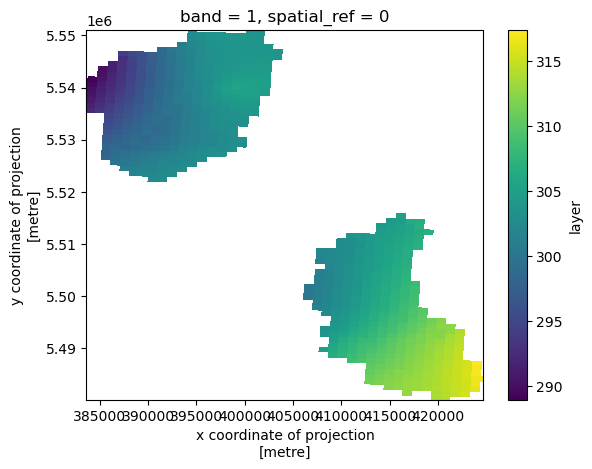

In [25]:
rad_mosaic.plot()

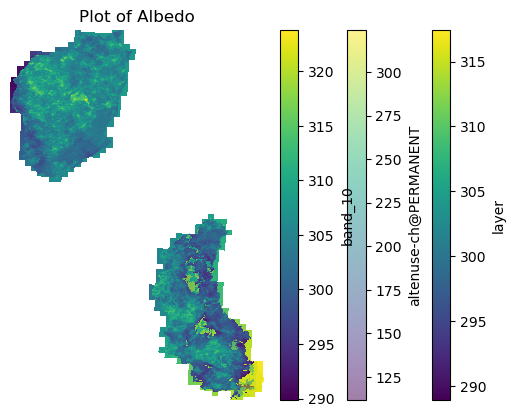

In [31]:
# Plot the data - all raster seems to align
f, ax=plt.subplots()
rad_mosaic.plot.imshow(ax=ax)
LU_mosaic.plot.imshow(ax=ax, alpha = 0.5)
LS_stack.band_10.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("Plot of Albedo")
plt.show()

### 2.4 RL - Outgoing Longwave Radiation

Surface Emissivity (C, 2.), Thermal Radiance (C, 3.), Surface Temperature (C, 4.) are not needed at the moment because we already got Surface Temperature from Landsat Level 2


In [34]:
print("Max LAI:", np.nanmax(LAI.values))

Max LAI: 11.042611


In [37]:
emis_null = xr.where((LAI < 3) | LAI.isnull(), 0.95 + 0.01*LAI, 0.98)
emis_null

<xarray.DataArray (y: 2367, x: 1369)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 3.836e+05 3.837e+05 ... 4.246e+05 4.247e+05
  * y            (y) float64 5.551e+06 5.551e+06 5.551e+06 ... 5.48e+06 5.48e+06
    spatial_ref  int32 0

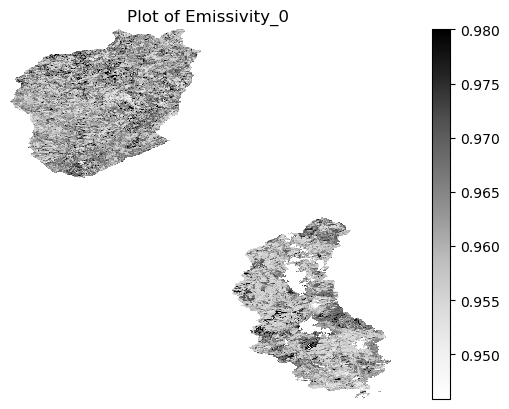

In [38]:
# Plot the data
f, ax=plt.subplots()
emis_null.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of Emissivity_0")
plt.show()

In [39]:
# Outgoing Longwave Radiation
# typical Range: 200-700 W/m²
Ts = LS_stack.band_10    # Surface Temperature in Kelvin 
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4

RL_out = emis_null * sigma * Ts**4
RL_out

<xarray.DataArray (y: 2367, x: 1369)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 3.836e+05 3.837e+05 ... 4.246e+05 4.247e+05
  * y            (y) float64 5.551e+06 5.551e+06 5.551e+06 ... 5.48e+06 5.48e+06
    spatial_ref  int32 0

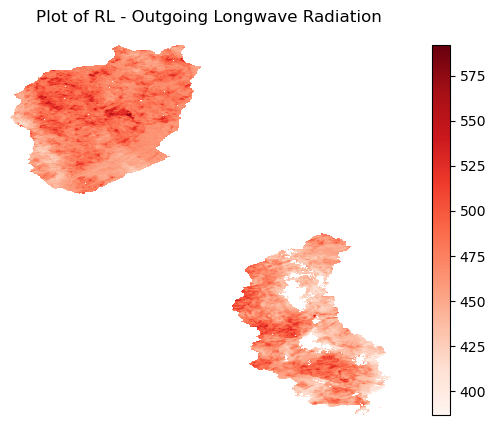

In [40]:
# Plot the data
f, ax=plt.subplots()
RL_out.plot.imshow(ax=ax,
                  cmap = "Reds")
ax.set_axis_off()
ax.set_title("Plot of RL - Outgoing Longwave Radiation")
plt.show()

### 2.5 RL - Incoming Longwave Radiation

In [38]:
# Incoming Longwave Radiation
# typical Range: 200-500 W/m²
Tcold = 290             # Assuming Tcold is 290 Kelvin, based on band_10 Histogram
Ta = Tcold              # Near Surface Air Temperature in Kelvin from T_cold (T Cold Pixel)
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4
emis_atmo = 0.85 * (-np.log(tau_sw))**0.09  # Empirical Formula for Atmospheric Emissivity

RL_in = emis_atmo * sigma * Ta**4
RL_in

304.45143274489214

### 2.6 Solving vor Rn

In [41]:
# Solving for Net Surface Radiation Flux Rn
# typical Range: 100-700 W/m²
Rn = (1-albedo)*RS_in + RL_in - RL_out - (1-emis_null)*RL_in  # After SEBAL Manual

# Other Formula based on Allen 2007 / M.L. Fischer Script
# Rn_allen = RS_in - (albedo*RS_in) + RL_in - RL_out - (1-emis_null)*RL_in

NameError: name 'RL_in' is not defined

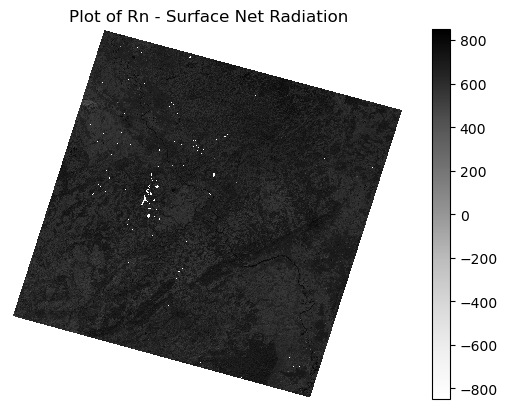

In [40]:
# Plot the data
f, ax=plt.subplots()
Rn.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of Rn - Surface Net Radiation")
plt.show()

In [32]:
# Replacing calculated Rn with rad_mosaic
Rn = rad_mosaic

## 3. Surface Energy Balance

### 3.1 G - Soil Heat Flux

In [42]:
# Soil Heat Flux
G_Rn_ratio = ((Ts-273.16)/albedo * ((0.0038*albedo)+(0.0075*(albedo**2)))*(1-0.98*(NDVI**4)))
G = G_Rn_ratio*Rn


print("Min:", np.nanmin(G_Rn_ratio.values))
print("Max:", np.nanmax(G_Rn_ratio.values))



Min: -0.19145882
Max: 0.56975627


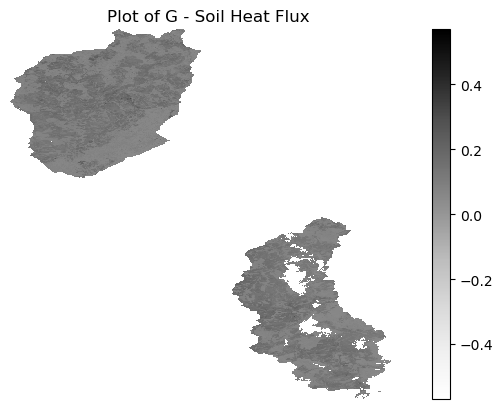

In [43]:
# Plot the data
f, ax=plt.subplots()
G_Rn_ratio.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G - Soil Heat Flux")
plt.show()

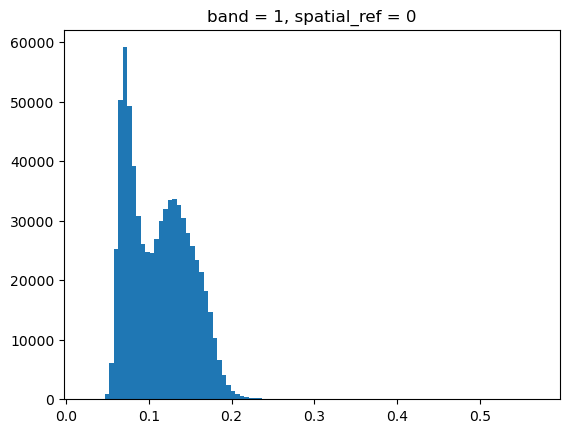

In [44]:
G_Rn_ratio_filt = G_Rn_ratio.where(G_Rn_ratio>0)
G_filt = G.where(G_Rn_ratio>0)

G_Rn_ratio_filt.plot.hist(bins = 100)
plt.show()

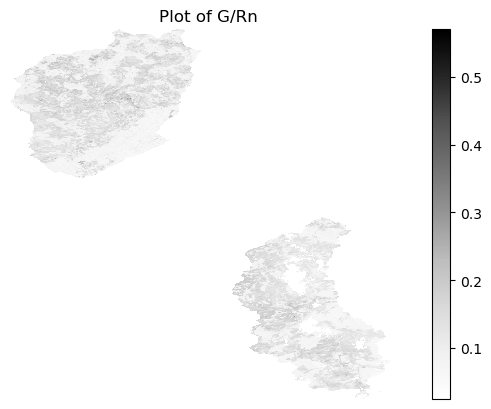

In [45]:
# Plot the data
f, ax=plt.subplots()
G_Rn_ratio_filt.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G/Rn")
plt.show()

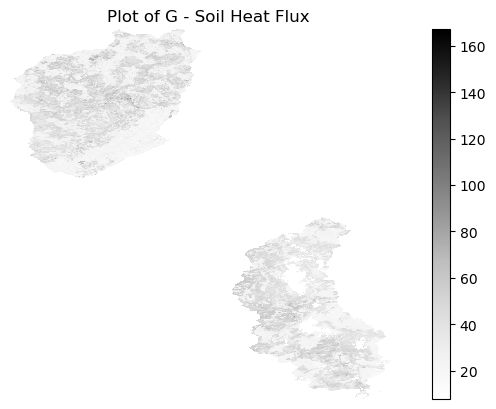

In [46]:
# Plot the data
f, ax=plt.subplots()
G_filt.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G - Soil Heat Flux")
plt.show()

### 3.2 H - Sensible Heat Flux

#### 3.2.1 Aerodynamic Resistance r_ah

In [59]:
# For Wind data from Station --> either convert station data to raster or use index of raster to create two areas
wind_df.loc[date][1]

# Create Wind Raster


0.1

In [58]:
# r_ah for neutral stability
# Final Formula: r_ah = (np.log(z2/z1)) / (u_asterix * k)
# Values are just assumed for testing, later taken from actual weather data according to the station
k = 0.41    # Karmans constant

ux = 20    # Wind speed at height zx (m/s)
zx = 2      # Height x with measured Wind speed ux
h_veg = 0.5      # Vegetation Heigh in m at weather station
zom_station = 0.12*h_veg   # momentum roughness length (m) at the weather station, SEBAL Manual suggests 0.12*height_vegetation


In [48]:
# 1. Friction veolocity u_asterix --> logaritmic wind profile
u_asterix = (k*ux) / (np.log(zx / zom_station))
u_asterix

2.338475576367114

In [49]:
# 2. Wind speed at 200m above ground u200
u200 = u_asterix * ((np.log(200/zom_station)) / k)
u200

46.26604391450525

In [50]:
# 3. Friction Velocity u_asterix_px for each Pixel 
#zom_px =  exp()          # Momentum roughness length (m) for each Pixel of the Image

#u_asterix_px = (k*u200) / (np.log(200 / zom_px))

# Assumed, simple variante (only for agriculture viable)
zom_px = 0.018 * LAI
u_asterix_px = (k*u200) / (np.log(200/zom_px))

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [51]:
# 4. Initial Aerodynamic resistance r_ah
z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual

r_ah = (np.log(z2/z1)) / (u_asterix_px * k)

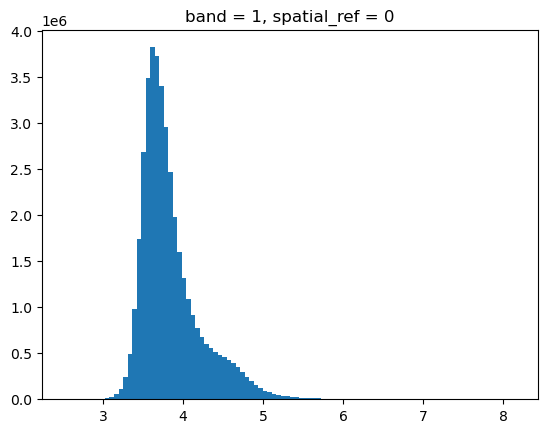

In [52]:
r_ah.plot.hist(bins = 100)
plt.show()

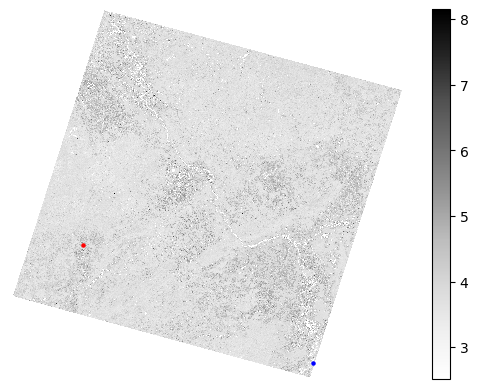

In [53]:
# Plot the data
f, ax=plt.subplots()
r_ah.plot.imshow(ax=ax,
                  cmap = "Greys")
plt.scatter([3.227e+05],[5.537e+06], color='red', s=5)
plt.scatter([4.616e+05],[5.46e+06], color='blue', s=5)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [54]:
# 5. Compute H from dT (near surface temperature difference)
# Compute H and dT for hot and cold anchor pixels

# COLD PIXEL
# Test with assumption that Hcold = 0 over water bodie with zero sensible heat flux

H_cold = 0
dT_cold = 0


# HOT PIXEL
H_hot = Rn - G
# Get r_ah for Hot Pixel after filtering r_ah non NAN
Ts_nonan = Ts.where(((np.isnan(r_ah) == False)), drop = True)
r_ah_hot = r_ah.where(Ts==Ts_nonan.max(), drop = True)
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
cp = 1004           # Air specific heat (J/kg/K)
dT_hot = H_hot * r_ah_hot / (roh_hot*cp)

In [55]:
# 5.1 Linear Regression on T against dT --> get coeffiients b and a
Ts_cold = Ts_nonan.min()
Ts_hot = Ts_nonan.max()

# Create Arrays for Linear Regression
Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
dT_linreg = np.array([dT_cold, dT_hot.item()])

# Build Linear Model
dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

# Extract Coefficients after dT = b + a*Ts
coeff_b = dT_model.intercept_
coeff_a = dT_model.coef_ 

In [56]:
# 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
dT_pix = coeff_b + coeff_a*Ts_nonan

In [57]:
# 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
Ta_pix = Ts_nonan - dT_pix

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K

roh_pix = pressure / (Rs_constant * Ta_pix)

In [58]:
# 7. Calculate Sensible Heat Flux H with initial r_ah under neutral atmospheric conditions
H = (roh_pix * cp * dT_pix) / r_ah



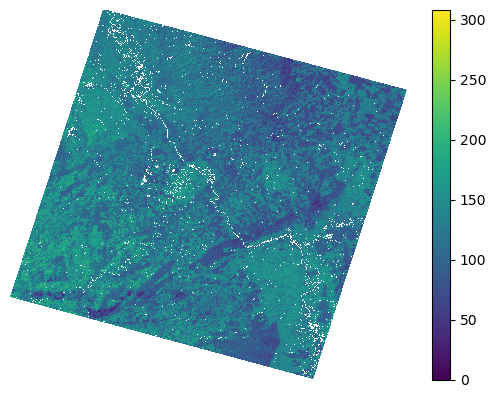

In [59]:
# Plot the data
f, ax=plt.subplots()
H.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [60]:
# 8. Stability correction/iteration
g = 9.81    # Gravitational constant, m/s²

# Monin-Obukhov Length L_mo
L_mo = -(roh_pix * cp * u_asterix_px**3 * Ts) / (k * g * H)




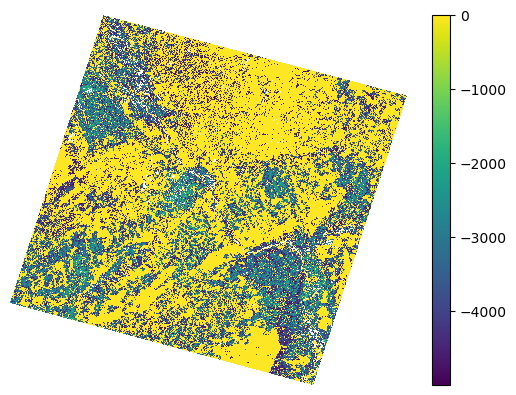

In [61]:
# Plot the data
data = L_mo > -5000
data = L_mo * data

f, ax=plt.subplots()
data.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [62]:
L_mo_filt = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)
L_mo_filt

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

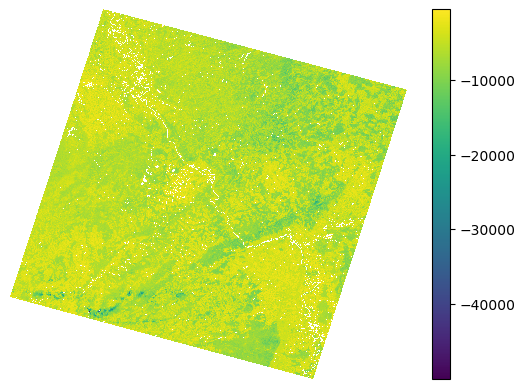

In [63]:
f, ax=plt.subplots()
L_mo_filt.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

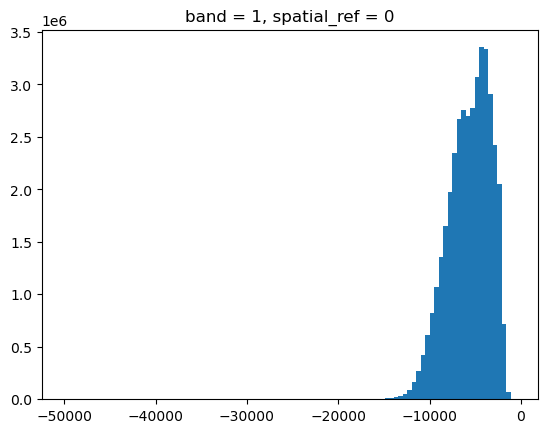

In [64]:
L_mo_filt.plot.hist(bins = 100)
plt.show()

In [65]:
# Coefficients for correction functions below
L_mo = L_mo_filt

x_200 = (1-(16*200/L_mo))**0.25
x_2 = (1-(16*2/L_mo))**0.25
x_01 = (1-(16*0.1/L_mo))**0.25

In [66]:
# Corections for momentum psi_m and heat transport psi_h 
# 1. Correction for psi_m_200

# if L_mo < 0
psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
# if L_mo > 0
psi_m_200_pos = -5*(2/L_mo)



psi_m_200 = L_mo    
psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

psi_m_200

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

In [67]:
x_val = 5200
y_val = 5200

print("L_mo =", L_mo[x_val, y_val])
print("psi_m_200_neg =", psi_m_200_neg[x_val, y_val])
print("psi_m_200_pos =", psi_m_200_pos[x_val, y_val])
print("psi_m_200 =", psi_m_200[x_val, y_val])

      

L_mo = <xarray.DataArray ()>
array(-2389.50684395)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200_neg = <xarray.DataArray ()>
array(0.24769406)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200_pos = <xarray.DataArray ()>
array(0.00418496)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200 = <xarray.DataArray ()>
array(0.24769406)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0


In [68]:
# Corections for momentum psi_m and heat transport psi_h 
# 2. Correction for psi_h_2

# if L_mo < 0
psi_h_2_neg = 2*np.log((1+x_2**2)/2)
# if L_mo > 0
psi_h_2_pos = -5*(2/L_mo)



psi_h_2 = L_mo    
psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 

psi_h_2

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

In [69]:
# Corections for momentum psi_m and heat transport psi_h 
# 3. Correction for psi_h_01

# if L_mo < 0
psi_h_01_neg = 2*np.log((1+x_01**2)/2)
# if L_mo > 0
psi_h_01_pos = -5*(0.1/L_mo)



psi_h_01 = L_mo    
psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 

psi_h_01

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

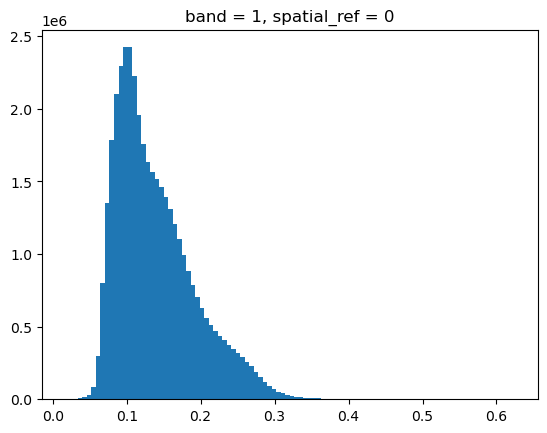

In [70]:
psi_m_200.plot.hist(bins = 100)
plt.show()

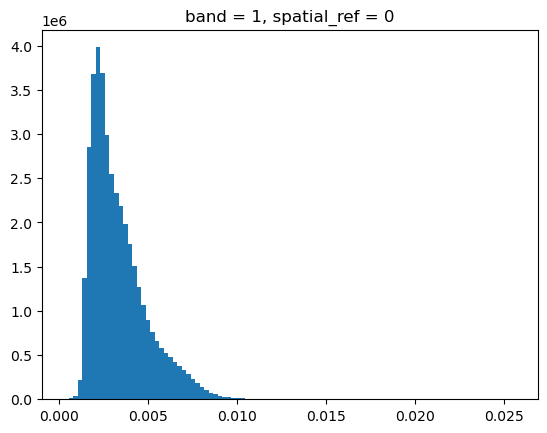

In [71]:
psi_h_2.plot.hist(bins = 100)
plt.show()

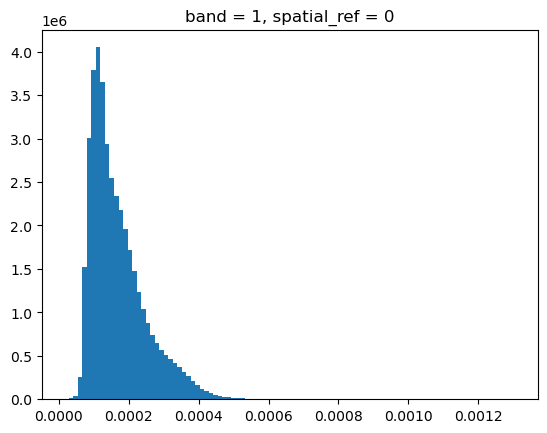

In [72]:
psi_h_01.plot.hist(bins = 100)
plt.show()

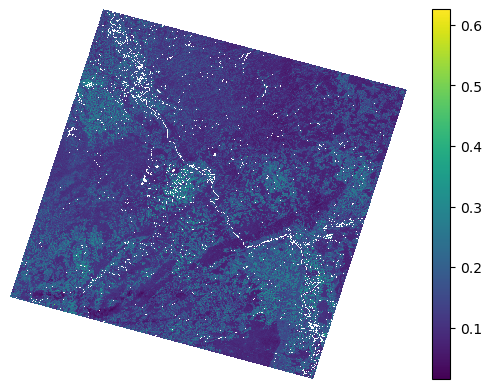

In [73]:
f, ax=plt.subplots()
psi_m_200.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

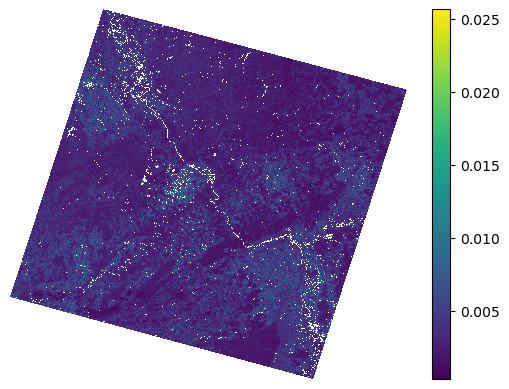

In [74]:
f, ax=plt.subplots()
psi_h_2.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

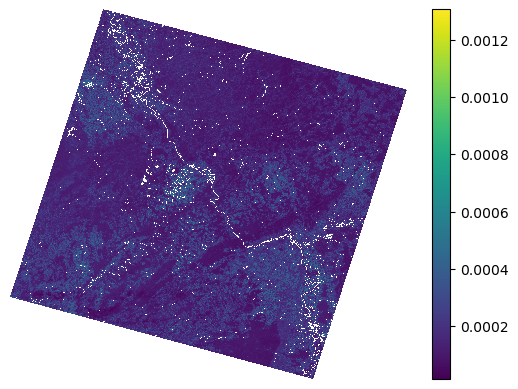

In [75]:
f, ax=plt.subplots()
psi_h_01.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


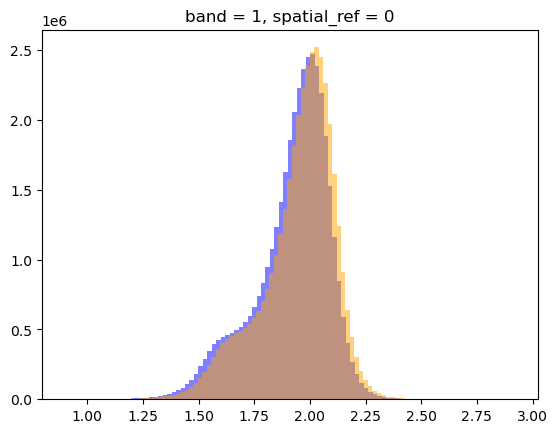

In [76]:
# 9. Calculate corrected Friction Velocity u_asterix_corr
u_asterix_corr = (k*u200) / (np.log(200/zom_px) - psi_m_200)

u_asterix_px.plot.hist(bins = 100, alpha = 0.5, color = "blue")
u_asterix_corr.plot.hist(bins = 100, alpha = 0.5, color = "orange")
plt.show()

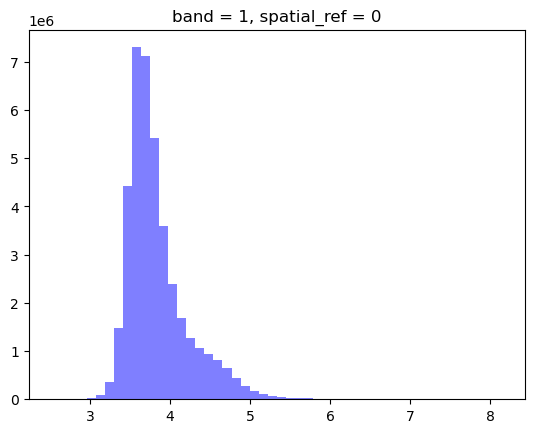

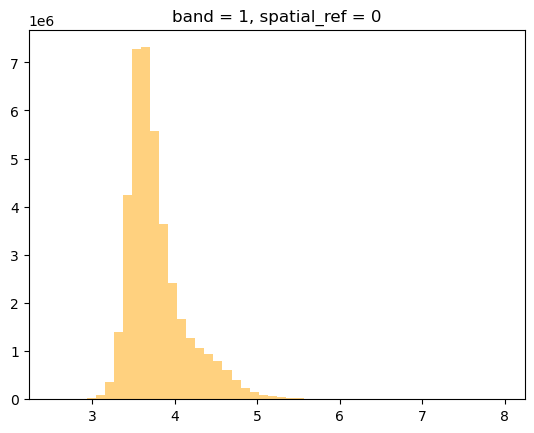

In [77]:
# 10. Corrected Areodynamic Resistance r_ah is calculated

# Initial r_ah:
# z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
# z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual
# r_ah = (np.log(z2/z1)) / (u_asterix_px * k)

# Corrected r_ah_corr
r_ah_corr = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix_corr * k)

r_ah.plot.hist(bins = 50, alpha = 0.5, color = "blue")
plt.show()

r_ah_corr.plot.hist(bins = 50, alpha = 0.5, color = "orange")
plt.show()

In [81]:
# 11. Add all steps into for loop
# Outside Loop
# COLD PIXEL
# Test with assumption that Hcold = 0 over water bodie with zero sensible heat flux
H_cold = 0
dT_cold = 0

# HOT PIXEL
H_hot = Rn - G
Ts_nonan = Ts.where(((np.isnan(r_ah) == False)), drop = True)
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
                    # Method after M.L. Fischer: roh_hot = (P *100)/ ((LST - dT) * Rs)
cp = 1004           # Air specific heat (J/kg/K)

# 5.1 Linear Regression on T against dT --> get coeffiients b and a
Ts_cold = Ts_nonan.min()
Ts_hot = Ts_nonan.max()

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K

g = 9.81    # Gravitational constant, m/s²

# Create Data Frame to save updated values during iteration
cols = ["Iteration", "r_ah_hot", "dT_hot"]
df_stabcorr = pd.DataFrame(columns=cols, index = range(15))


# Inside Loop
for i in range(15):
    # 5. Compute H from dT (near surface temperature difference)
    # Compute H and dT for hot and cold anchor pixels
    
    # Get r_ah for Hot Pixel after filtering r_ah non NAN
    r_ah_hot = r_ah.where(Ts==Ts_nonan.max(), drop = True)
    dT_hot = H_hot * r_ah_hot / (roh_hot*cp)
    
    # 5.1 Linear Regression on T against dT --> get coeffiients b and a
    # Create Arrays for Linear Regression
    Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
    dT_linreg = np.array([dT_cold, dT_hot.item()])

    # Build Linear Model
    dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

    # Extract Coefficients after dT = b + a*Ts
    coeff_b = dT_model.intercept_
    coeff_a = dT_model.coef_ 
    
    # 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
    dT_pix = coeff_b + coeff_a*Ts_nonan
    
    # 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
    Ta_pix = Ts_nonan - dT_pix

    roh_pix = pressure / (Rs_constant * Ta_pix)

    # 7. Calculate Sensible Heat Flux H with updated r_ah
    H = (roh_pix * cp * dT_pix) / r_ah
    
    # 8. Stability correction/iteration
    # Monin-Obukhov Length L_mo
    L_mo = -(roh_pix * cp * u_asterix_px**3 * Ts) / (k * g * H)
    
    # Filter -inf values
    L_mo_ = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)
    
    # Coefficients for Corrections functions below
    x_200 = (1-(16*200/L_mo))**0.25
    x_2 = (1-(16*2/L_mo))**0.25
    x_01 = (1-(16*0.1/L_mo))**0.25

    #####################################
    # Corections for momentum psi_m and heat transport psi_h 
    #####################################
    # 1. Correction for psi_m_200
    #####################################
    # if L_mo < 0
    psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
    # if L_mo > 0
    psi_m_200_pos = -5*(2/L_mo)

    psi_m_200 = L_mo    
    psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
    psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

    #####################################
    # 2. Correction for psi_h_2
    #####################################
    # if L_mo < 0
    psi_h_2_neg = 2*np.log((1+x_2**2)/2)
    # if L_mo > 0
    psi_h_2_pos = -5*(2/L_mo)

    psi_h_2 = L_mo    
    psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
    psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 
    
    #####################################
    # 3. Correction for psi_h_01
    #####################################
    # if L_mo < 0
    psi_h_01_neg = 2*np.log((1+x_01**2)/2)
    # if L_mo > 0
    psi_h_01_pos = -5*(0.1/L_mo)

    psi_h_01 = L_mo    
    psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
    psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 
    
    #####################################
    
    # 9. UPDATE u and r_ah: Calculate corrected Friction Velocity u_asterix_px / 
    u_asterix_px = (k*u200) / (np.log(200/zom_px) - psi_m_200)
    
    # 10. UPDATE u and r_ah: Corrected Areodynamic Resistance r_ah is calculated
    r_ah = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix_px * k)
    
    # Save values to Stability Correction DataFrame
    df_stabcorr.loc[i].Iteration = i
    df_stabcorr.loc[i].r_ah_hot = r_ah_hot
    df_stabcorr.loc[i].dT_hot = dT_hot
    


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:76

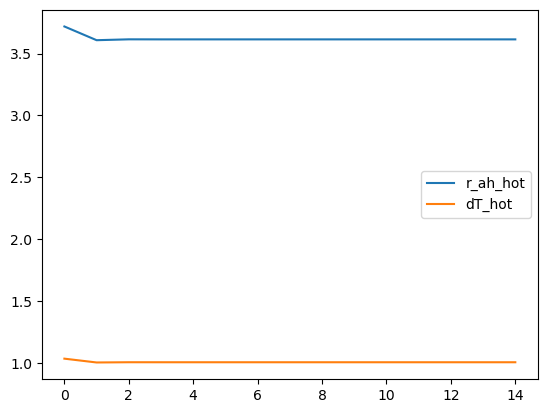

In [131]:
# Plot Change in Stability correction values
plt.plot(df_stabcorr.r_ah_hot, label = df_stabcorr.columns[1])
plt.plot(df_stabcorr.dT_hot, label = df_stabcorr.columns[2])
plt.legend()
plt.show()

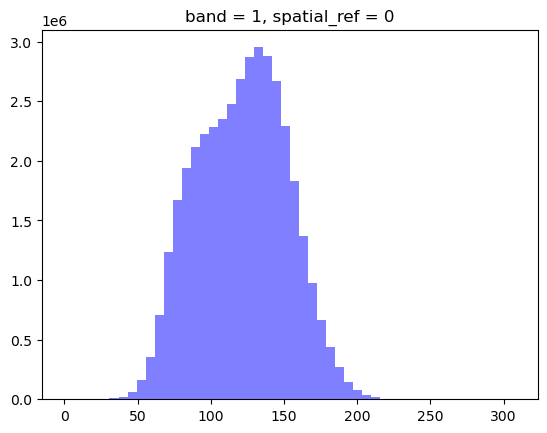

In [132]:
H.plot.hist(bins = 50, alpha = 0.5, color = "blue")
plt.show()

### 3.3 ET - Latent Heat Flux

In [133]:
# Quick and Dirty Calculation of ET (to this point without iterative correction)
ETL = Rn - G_filt - H
ETL = ETL.where(ETL>=0)


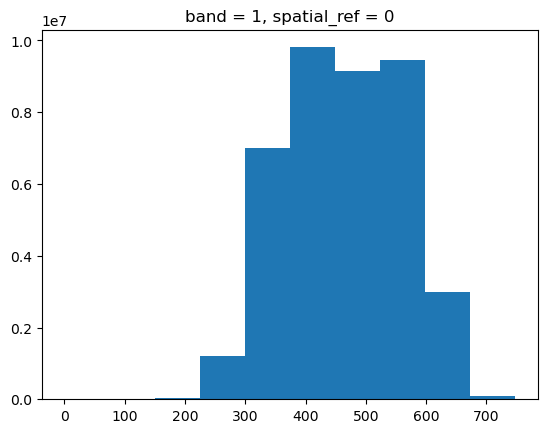

In [134]:
ETL.plot.hist()
plt.show()

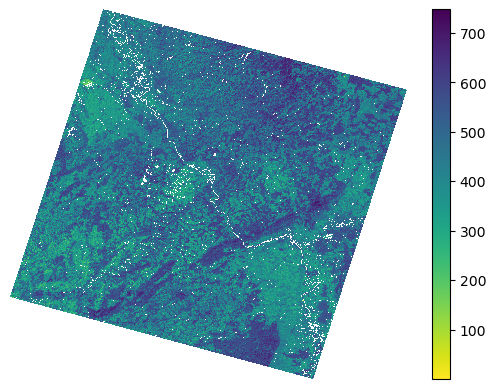

In [135]:
# Plot the data
f, ax=plt.subplots()
ETL.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

(array([4.510000e+02, 2.998000e+03, 4.143200e+04, 1.212377e+06,
        7.015240e+06, 9.808131e+06, 9.148622e+06, 9.461906e+06,
        2.999968e+06, 1.030790e+05]),
 array([3.77664325e-04, 1.19994053e-01, 2.39610441e-01, 3.59226829e-01,
        4.78843217e-01, 5.98459606e-01, 7.18075994e-01, 8.37692382e-01,
        9.57308770e-01, 1.07692516e+00, 1.19654155e+00]),
 <BarContainer object of 10 artists>)

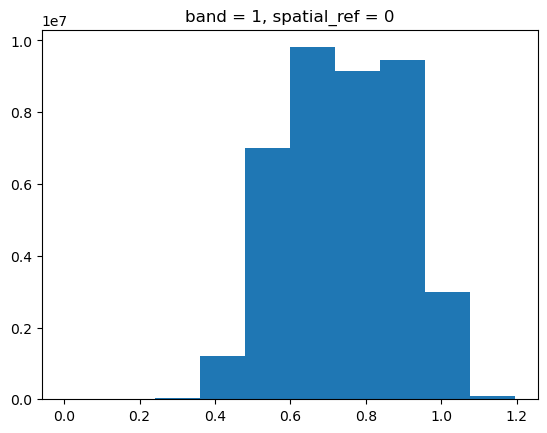

In [136]:
# From ET_lambda to ET in mm/hour
lamda = 2.25 * 10**6 # Latet heat of Vaporization J/kg
ET_inst = 3600* (ETL / lamda)

ET_inst.plot.hist()

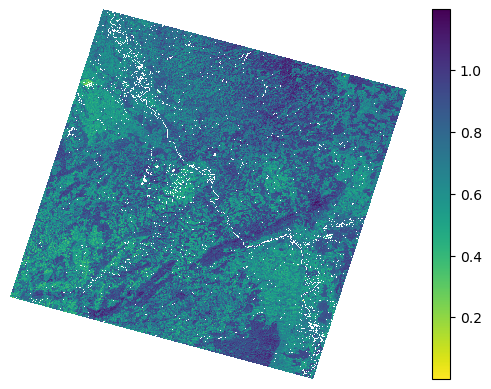

In [137]:
# Plot the data
f, ax=plt.subplots()
ET_inst.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()